# Demo Overview-Detail imaging on simulated data

As a framework for automated microscopy, ```autoSTED``` requires the presence of a microscope controlled through Imspector for normal operation.

For testing on different systems, in this notebook, we perform **virual microscopy by cutting images from an existing (tiled) dataset.**

Again we take advantage of the flexibility of autoSTED: we provide a ```DemoImspectorConnection``` class (replacing the default ```ImspectorConnection``` that handles all interactions normally) to simulate microscopy in an existing dataset.

## Test dataset

We provide a tiled confocal dataset of 7x7 75µm (x) by 75µm (y) by 10µm (z) stacks of newly replicated DNA stained by STAR635P conjugated via click chemistry to EdU incorporated into C2C12 mouse fibroblasts during a 10min pulse. The dataset was acquired unsing autoSTED and saved in a combined HDF5 file.

The test dataset is available from https://osf.io/et4br/?view_only=23d060ed9a8f48b6863852ed65ac2c45

## Limitations

The simulated microscopy provided here is limited. While pipelines can be built as usual, and arbitrary AcquisitionTaskGenerators can be used, the only parameters that are respected are FOV position (scan/stage offsets), FOV length and pixel size. Furthermore, we only use data of the first channel in the demo dataset (the example above only contains one channel).

In [11]:
# setup logging
import logging
logging.basicConfig(level=logging.INFO)

from autosted.data import HDF5DataReader

dataset_path = "autosted-demo-c2c12-edu-001.h5"

# a HDF5DataReader object that acts like a dictionary of MeasurementData(s)
dataset = HDF5DataReader(dataset_path)

# get settings of first image
first_image_id = next(iter(dataset))
measurement_settings_first = dataset[first_image_id].measurement_settings[0]
hardware_settings_first = dataset[first_image_id].hardware_settings[0]

For both correct visualization and simulated microscopy, we need to know the stage and scan directions (e.g. whether larger physical coordinates correspond to larger pixel pixel coordinates in the resulting images).

The directions (1 if same as pixels, -1 if inverted) are set in ```autosted.utils.parameter_constants``` (if Imspector is running on the same computer, we load this automatically).

Below, we overwrite the directions to match those saved in the hardware parameters of out demo dataset.

In [2]:
import autosted.utils.parameter_constants

try:
    loaded_stage_direction = autosted.utils.parameter_constants.try_load_stage_directions(hardware_settings_first)
    autosted.utils.parameter_constants.DIRECTION_STAGE = loaded_stage_direction
except:
    pass

try:
    loaded_scan_direction = autosted.utils.parameter_constants.try_load_scan_directions(hardware_settings_first)
    autosted.utils.parameter_constants.DIRECTION_SCAN = loaded_scan_direction
except:
    pass

# check loaded directions
autosted.utils.parameter_constants.DIRECTION_STAGE, autosted.utils.parameter_constants.DIRECTION_SCAN 

((1, 1, -1), (1, 1, 1))

## Visualization

Here, we take all images in the dataset (skipping all but the lowest hierarchy level), stitch them into one image and display a maximum projection.

registered 49 images. fusing...


100%|██████████| 25/25 [00:39<00:00,  1.58s/it]

fused image shape: (19, 2477, 2468)


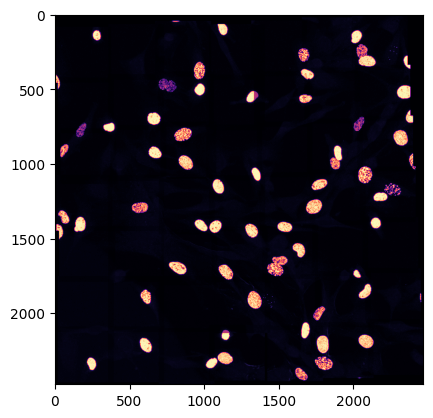

In [3]:
from matplotlib import pyplot as plt

from calmutils.stitching import stitch, translation_matrix, scale_matrix
from calmutils.stitching.fusion import fuse_image_blockwise
from autosted.utils.coordinate_utils import virtual_bbox_from_settings
from autosted.utils.parameter_constants import PIXEL_SIZE_PARAMETERS
from autosted.utils.dict_utils import get_parameter_value_array_from_dict

imgs = []
transforms = []

# collect image data and virtual transformations from dataset
for measurement in dataset:

    # we only take images of the lowest level (skip unless index of length 1)
    if len(measurement) != 1:
        continue

    # get settings of configuration 0
    measurement_settings = dataset[measurement].measurement_settings[0]
    start, fov = virtual_bbox_from_settings(measurement_settings)
    pixel_size = get_parameter_value_array_from_dict(measurement_settings, PIXEL_SIZE_PARAMETERS)

    # build (pixel-unit) transform matrix from coordinates
    transform = translation_matrix((start / pixel_size))
    # get data (configuration 0, channel 0)
    img = dataset[measurement].data[0][0].squeeze()

    imgs.append(img)
    transforms.append(transform)

# stitch - will give transforms relative to first img
transforms = stitch(imgs, [tr[:-1,-1] for tr in transforms], corr_thresh=0.9)
print(f"registered {len(imgs)} images. fusing...")

# fusing the images at full resolution can take several minutes
# by setting scale factors < 1, we can downsample for a faster result
scale_factors = [0.5, 0.5, 0.5]
transforms = [scale_matrix(scale_factors) @ tr for tr in transforms]

# fuse image (multithreaded in blocks) and display max projection
fused_img = fuse_image_blockwise(imgs, transforms, block_size=(32,512,512))
print(f"fused image shape: {fused_img.shape}")
plt.imshow(fused_img.max(0), cmap="magma")

As in the other examples, we need a starting point for our acquisitions - since we don't have Imspector, we use the stage coordinates of the first image of our dataset.

In [3]:
from autosted.utils.parameter_constants import OFFSET_STAGE_GLOBAL_PARAMETERS
from autosted.utils.dict_utils import get_parameter_value_array_from_dict

start_coords = get_parameter_value_array_from_dict(measurement_settings_first, OFFSET_STAGE_GLOBAL_PARAMETERS)

As we will be simulating overview-detail imaging, we define a simple segmentation function:

Here, we use a simple thresholding-based segmentation that we will wrap in a ```SegmentationWrapper```

In [4]:
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter, label
from skimage.morphology import dilation, disk, ball, remove_small_objects

def segment(img):
    # blur and Otsu threshold
    g = gaussian_filter(img.astype(float), 5)
    t = max(3, threshold_otsu(g))
    binary_img = g > t
    remove_small_objects(binary_img, 100)
    # label connected components, dilate
    labels, _ = label(binary_img)
    labels = dilation(labels, disk(3) if img.ndim==2 else ball(3))
    return labels

## Running the pipeline

The only real change we need to make to run an ```autoSTED``` pipeline on the simulated data is to exchange the ```imspector_connection``` of our pipeline object with a ```DemoImspectorConnection```. The "acquired" images will be saved as TIFF files instead of the Imspector .msr files.

**Note:** (Maximum projections of) all simulated acquired images will be displayed in the "magma" colormap. As the detection callbacks also show their results, overview images will be plotted a second time in grayscale with overlaid detection (bounding boxes).

Here, we take single plane xy overviews (with 200nm pixel size), followed by "higher resolution" stacks (5µm z-stacks with 200nm spacing, 50nm xy pixel size).

In [ ]:
from autosted import AcquisitionPipeline
from autosted.callback_buildingblocks import (JSONSettingsLoader,
                                              FOVSettingsGenerator,
                                              LocationKeeper, LocationRemover,
                                              NewestSettingsSelector,
                                              ScanModeSettingsGenerator,
                                              SpiralOffsetGenerator)

from autosted.detection import SegmentationWrapper
from autosted.imspector.demo_imspector_connection import DemoImspectorConnection
from autosted.stoppingcriteria import MaximumAcquisitionsStoppingCriterion
from autosted.taskgeneration import AcquisitionTaskGenerator

# pipeline with two levels: 'overview', 'detail'
pipeline = AcquisitionPipeline(
    data_save_path="acquisition_data/test",
    hierarchy_levels=["overview", "detail"],
)

# set demo Imspector connection to run on simulated data
# NOTE: needs to be done before starting the run
imspector = DemoImspectorConnection(dataset_path, register_images=True, plot_cmap="magma")
pipeline.imspector_connection = imspector

next_overview_generator = AcquisitionTaskGenerator(
    "overview",
    # 1. use parameters from dataset as basis
    JSONSettingsLoader(measurement_settings_first),
    # 2. xy scan mode
    ScanModeSettingsGenerator("xy"),
    # 3. 75x75µm fields with large pixel sizes (200nm)
    FOVSettingsGenerator(lengths=[None, 75e-6, 75e-6], pixel_sizes=[None, 200e-9, 200e-9]),
    # 4. coordinates from spiral
    SpiralOffsetGenerator(
        move_size=[75e-6, 75e-6],
        start_position=start_coords,
    ),
)

# acquisition task generator for details
detail_generator = AcquisitionTaskGenerator(
    "detail",
    # 1. use parameters from dataset as basis
    LocationRemover(JSONSettingsLoader(measurement_settings_first)),
    # 2. locations (stage) from previous (overview) image
    LocationKeeper(NewestSettingsSelector()),
    # 3. set scan mode to xyz
    ScanModeSettingsGenerator("xyz"),
    # 4. 5µm z stacks with smaller pixel sizes (200nm z spacing, 50nm xy)
    # NOTE: xy FOV will be determined by the block below, so we leave it at None here
    FOVSettingsGenerator(lengths=[5e-6, None, None], pixel_sizes=[200e-9, 50e-9, 50e-9]),
    # 5. segmentation wrapper around segmentation function
    SegmentationWrapper(segment)
)



pipeline.add_callback(next_overview_generator, "overview")
pipeline.add_callback(detail_generator, "overview")

pipeline.add_stopping_condition(
    # maximum number of images per level
    MaximumAcquisitionsStoppingCriterion(
        max_acquisitions_per_level={"overview": 10, "detail": 20}
    )
)

pipeline.run(initial_callback=next_overview_generator)

## On-the-fly stitching and Cellpose-based detection

By exchanging building blocks, you can also use advanced functionality with the demo dataset and simulated microscopy.

Here, instead of the ```SegmentationWrapper``` above, we use a ```CellposeNucleusMidplaneDetector``` to detect cells in overviews using Cellpose (**NOTE:** You need to have Cellpose installed in your environment)

- we also get the image data to segment via a ```StitchedNewestDataSelector```, enabling on-the-fly stitching (our Cellpose-based detector will ignore cells at the border of images)
- to prevent imaging the same cells twice we add an ```AlreadyImagedFOVFilter```

INFO:autosted.imspector.demo_imspector_connection:Registering 49 images in virtual dataset.
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.core:** TORCH MPS version installed and working. **
INFO:cellpose.core:>>>> using GPU (MPS)
INFO:cellpose.models:>>>> loading model /Users/david/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspec

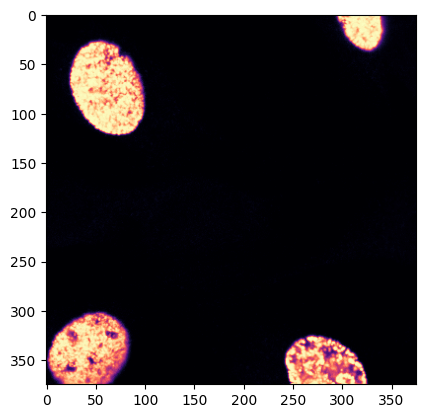

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.0007274400000000001)]


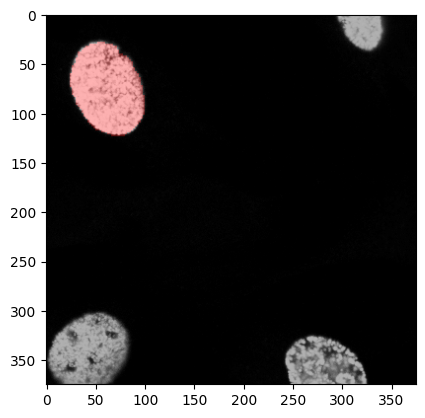

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.23e-05 -2.51e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(-2.2299999999999997e-05), np.float64(-2.5099999999999997e-05)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspector.demo_imspector_connection:FOV length: [5e-06, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]


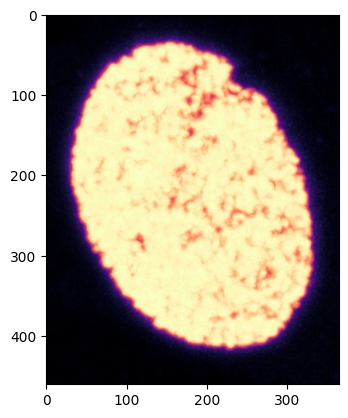

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


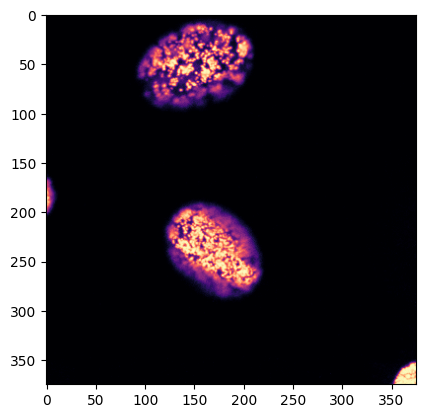

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.0007274400000000001)]
/Users/david/miniconda3/envs/env-py312/lib/python3.12/site-packages/skimage/color/colorlabel.py:149: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(


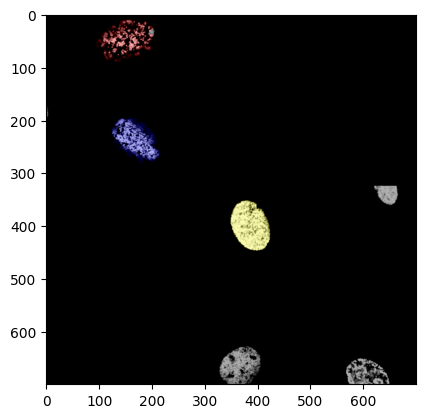

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.69e-05 -7.50e-06], FOV: [None, np.float64(2.16e-05), np.float64(2.7839999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  1.03e-05 -3.50e-06], FOV: [None, np.float64(2.2559999999999997e-05), np.float64(2.304e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [0.00e+00 4.25e-05 3.97e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(-2.6899999999999997e-05), np.float64(-7.499999999999999e-06)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspecto

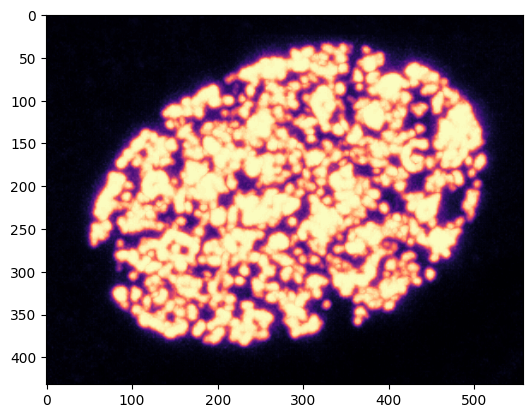

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(1.03e-05), np.float64(-3.499999999999997e-06)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspector.demo_imspector_connection:FOV length: [5e-06, np.float64(2.2559999999999997e-05), np.float64(2.304e-05)]


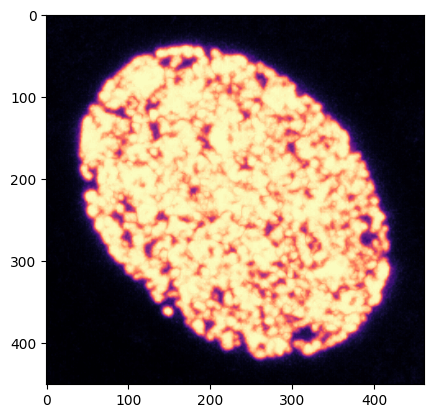

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


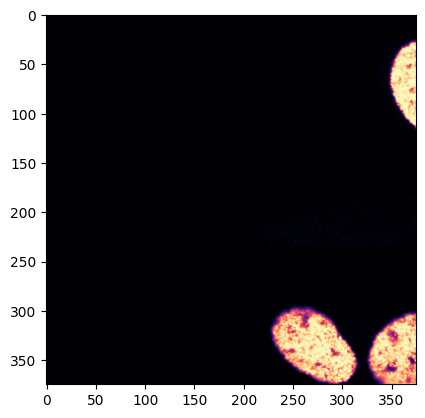

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.0007274400000000001)]


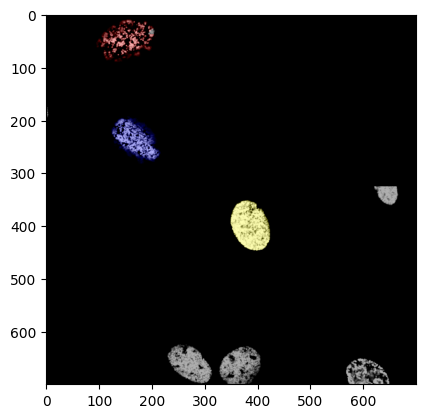

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -9.19e-05 -7.50e-06], FOV: [None, np.float64(2.16e-05), np.float64(2.7839999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -5.45e-05 -3.50e-06], FOV: [None, np.float64(2.304e-05), np.float64(2.304e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.25e-05  3.97e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


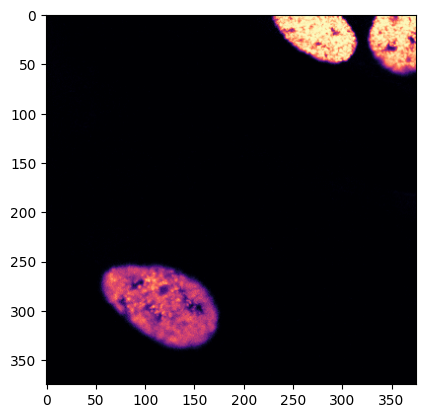

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00079244)]


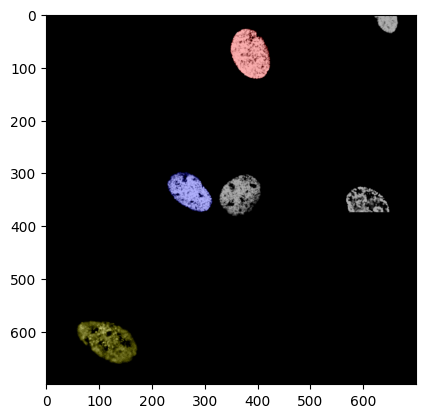

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -8.73e-05  3.97e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -3.51e-05  1.69e-05], FOV: [None, np.float64(1.872e-05), np.float64(2.112e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  2.17e-05 -1.45e-05], FOV: [None, np.float64(2.0639999999999996e-05), np.float64(2.8319999999999997e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(-3.51e-05), np.float64(1.6899999999999997e-05)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspector.demo_ims

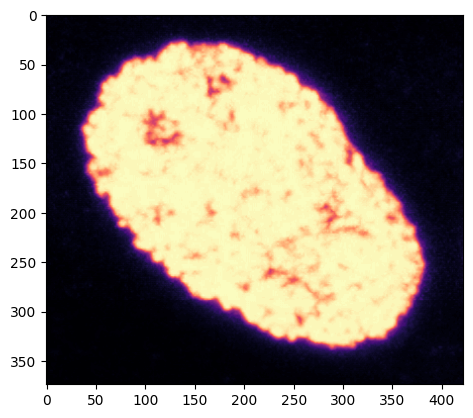

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.0007274400000000001)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(2.1699999999999985e-05), np.float64(-1.4499999999999997e-05)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspector.demo_imspector_connection:FOV length: [5e-06, np.float64(2.0639999999999996e-05), np.float64(2.8319999999999997e-05)]


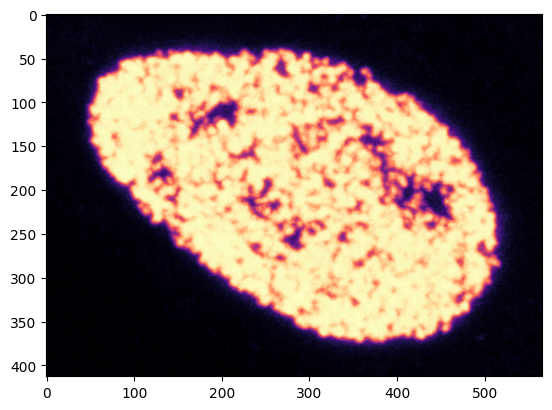

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


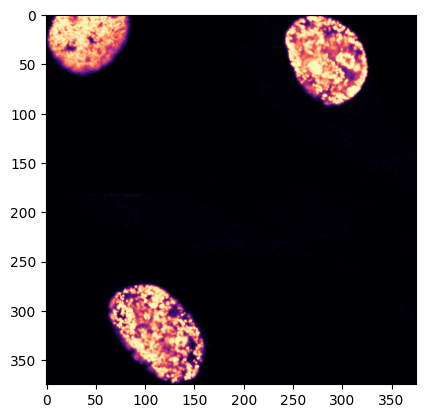

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00085744)]


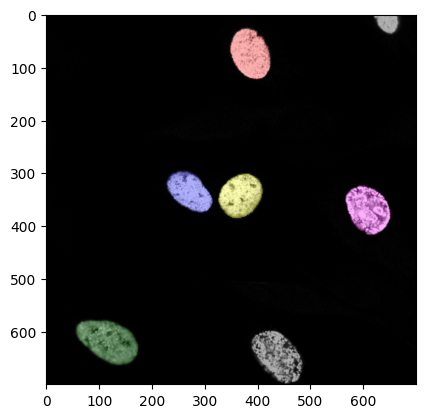

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -8.73e-05 -2.53e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -3.51e-05 -4.81e-05], FOV: [None, np.float64(1.872e-05), np.float64(2.112e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -3.37e-05 -2.89e-05], FOV: [None, np.float64(2.0159999999999997e-05), np.float64(2.0159999999999997e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.83e-05  1.93e-05], FOV: [None, np.float64(2.2559999999999997e-05), np.float64(2.0639999999999996e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  2.19e-05 -7.93e-05], FOV: [None, np.float64(2.0159999999999997e-05), np.float64(2.7839999999999998e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:aut

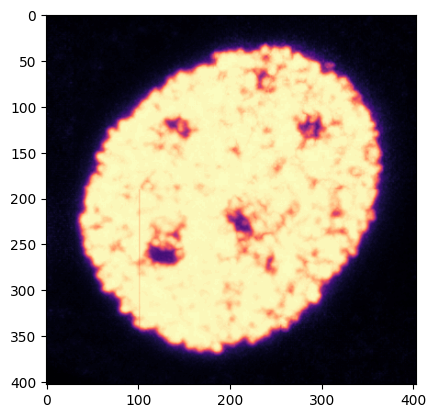

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(-2.8299999999999997e-05), np.float64(1.9299999999999995e-05)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspector.demo_imspector_connection:FOV length: [5e-06, np.float64(2.2559999999999997e-05), np.float64(2.0639999999999996e-05)]


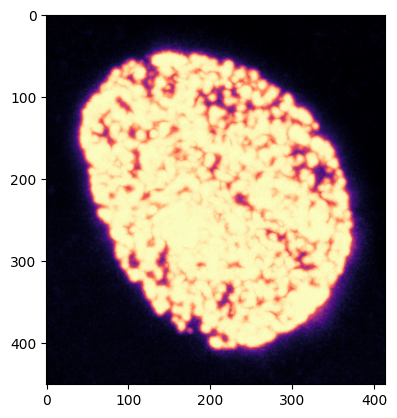

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00085744)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


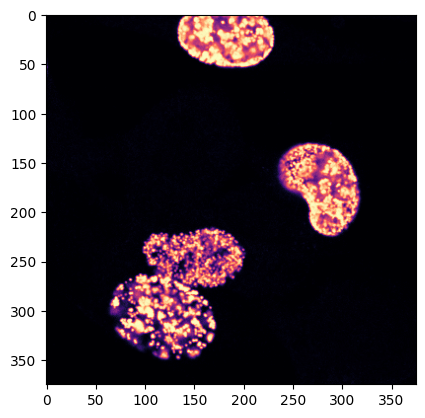

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.00085744)]


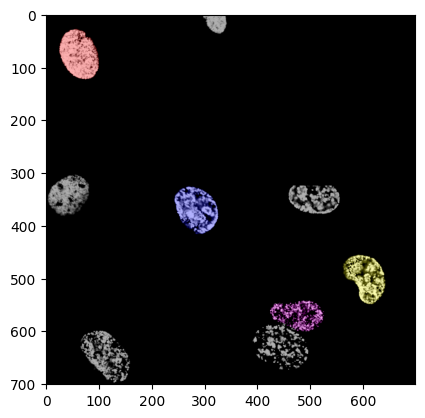

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -8.73e-05 -9.01e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.82e-05 -4.55e-05], FOV: [None, np.float64(2.2799999999999995e-05), np.float64(2.0639999999999996e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -1.90e-06  1.77e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.9679999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  1.19e-05 -7.50e-06], FOV: [None, np.float64(1.488e-05), np.float64(2.4479999999999996e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00085744)]
INFO:autosted.imspector.demo_imspector_connection:scan offs

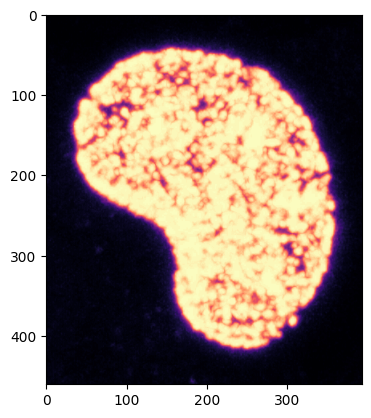

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00653452), np.float64(-0.00085744)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.float64(1.1899999999999991e-05), np.float64(-7.500000000000006e-06)]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xyz
INFO:autosted.imspector.demo_imspector_connection:FOV length: [5e-06, np.float64(1.488e-05), np.float64(2.4479999999999996e-05)]


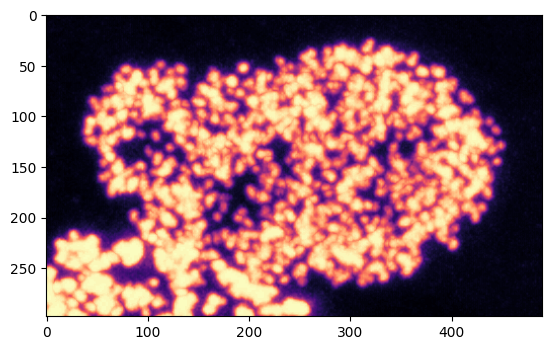

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00659952), np.float64(-0.00085744)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


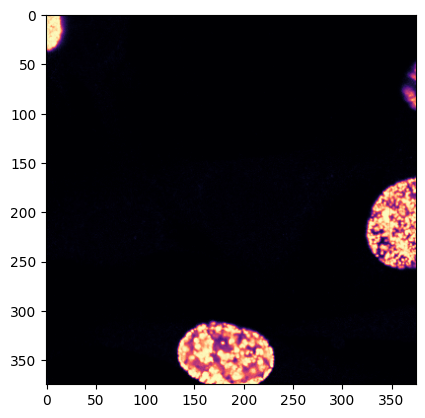

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.00085744)]


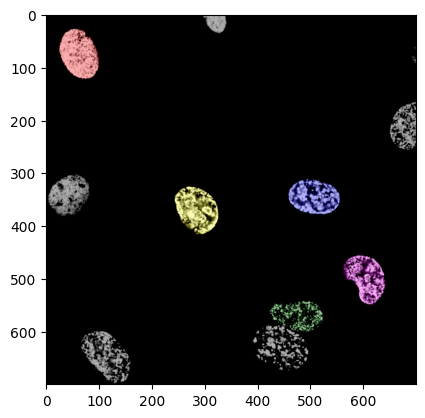

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.23e-05 -9.01e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  3.17e-05 -9.00e-07], FOV: [None, np.float64(1.6319999999999996e-05), np.float64(2.3999999999999997e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  3.67e-05 -4.55e-05], FOV: [None, np.float64(2.2559999999999997e-05), np.float64(2.0639999999999996e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [0.00e+00 6.31e-05 1.77e-05], FOV: [None, np.float64(2.352e-05), np.float64(1.9679999999999998e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  7.69e-05 -7.50e-06], FOV: [None, np.float64(1.44e-05), np.float64(2.4479999999999996e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autoste

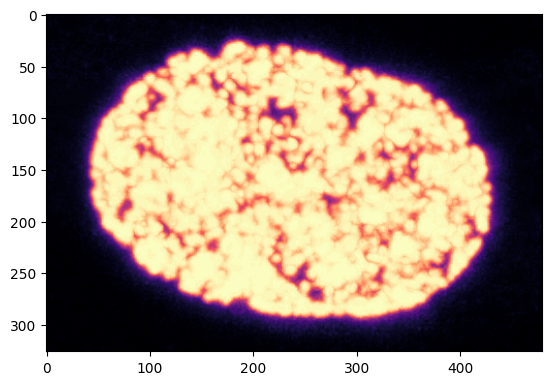

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.00085744)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


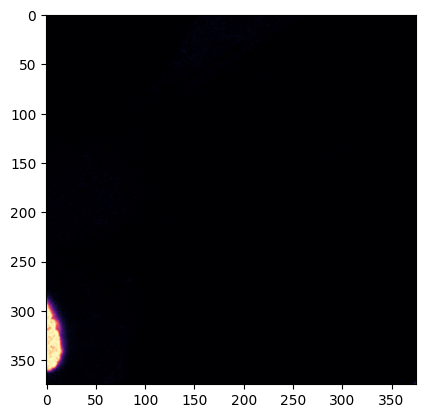

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.00079244)]


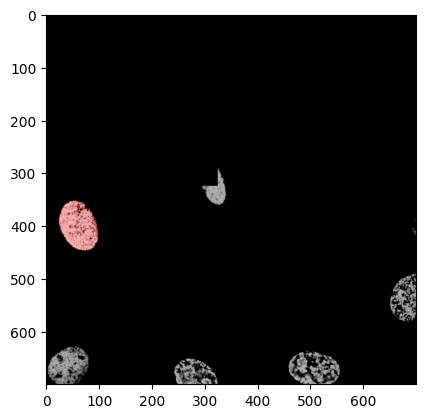

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  4.25e-05 -9.01e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


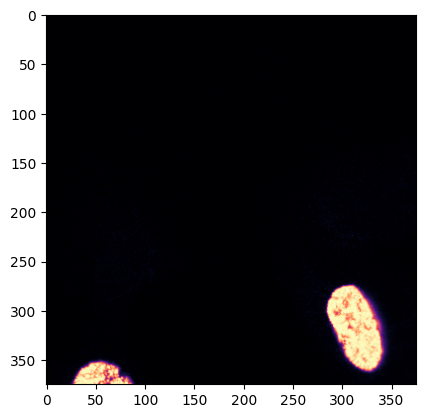

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00672952), np.float64(-0.00066244)]


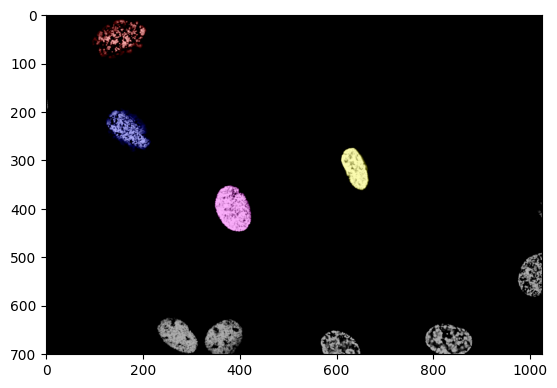

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00 -2.69e-05 -7.23e-05], FOV: [None, np.float64(2.112e-05), np.float64(2.736e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  1.05e-05 -6.85e-05], FOV: [None, np.float64(2.2559999999999997e-05), np.float64(2.304e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [0.00e+00 2.64e-05 2.51e-05], FOV: [None, np.float64(2.136e-05), np.float64(1.3919999999999999e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [ 0.00e+00  4.25e-05 -2.53e-05], FOV: [None, np.float64(2.304e-05), np.float64(1.8239999999999998e-05)]
INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.00079244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [np.float64(0.0), np.flo

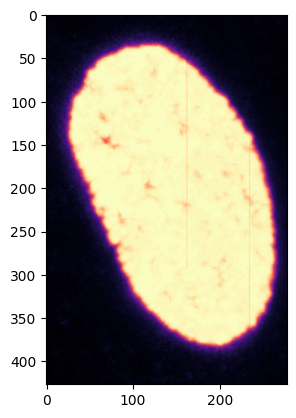

INFO:autosted.imspector.demo_imspector_connection:running simulated acquisition:
INFO:autosted.imspector.demo_imspector_connection:stage offsets: [np.float64(0.0019372), np.float64(-0.00672952), np.float64(-0.00066244)]
INFO:autosted.imspector.demo_imspector_connection:scan offsets: [0.0, 0.0, 0.0]
INFO:autosted.imspector.demo_imspector_connection:scan mode: xy
INFO:autosted.imspector.demo_imspector_connection:FOV length: [9.9e-06, 7.5e-05, 7.5e-05]


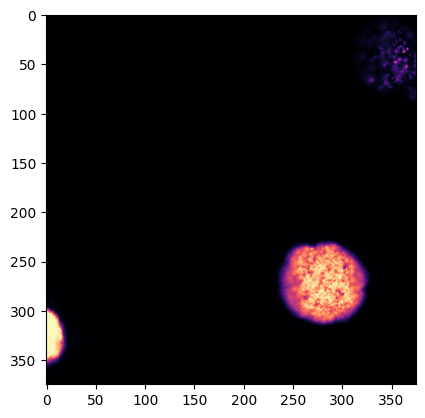

INFO:autosted.callback_buildingblocks.regular_position_generators:new coordinates in spiral: [np.float64(0.0019372), np.float64(-0.00666452), np.float64(-0.00066244)]
/Users/david/miniconda3/envs/env-py312/lib/python3.12/site-packages/calmutils/stitching/phase_correlation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  ccor_i = np.sum(patch1 * patch2) / np.sqrt(np.sum((patch1**2))) / np.sqrt(np.sum((patch2**2)))


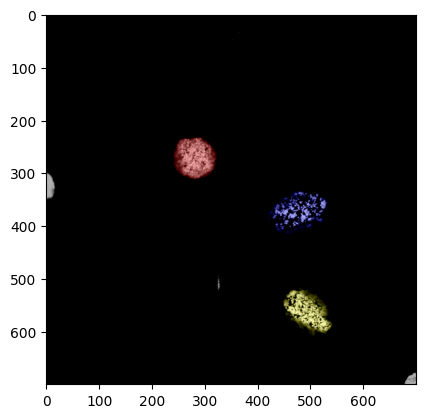

INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [0.00e+00 1.71e-05 1.87e-05], FOV: [None, np.float64(1.9679999999999998e-05), np.float64(2.16e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [0.00e+00 3.79e-05 5.75e-05], FOV: [None, np.float64(2.16e-05), np.float64(2.8319999999999997e-05)]
INFO:autosted.detection.legacy.nucleus_detection_legacy:Found Nucleus at [0.00e+00 7.55e-05 6.15e-05], FOV: [None, np.float64(2.2559999999999997e-05), np.float64(2.352e-05)]
INFO:autosted.pipeline:PIPELINE automatic-acquisition FINISHED


STOPPING PIPELINE automatic-acquisition: maximum number of acquisitions reached


In [6]:
from autosted.callback_buildingblocks import ScanFieldSettingsGenerator, StitchedNewestDataSelector
from autosted.detection.legacy import CellposeNucleusMidplaneDetector
from autosted.task_filtering import AlreadyImagedFOVFilter

# pipeline with two levels: 'overview', 'detail'
pipeline = AcquisitionPipeline(
    data_save_path="acquisition_data/test",
    hierarchy_levels=["overview", "detail"],
)

# set demo Imspector connection to run on simulated data
# NOTE: needs to be done before starting the run
imspector = DemoImspectorConnection(dataset_path, register_images=True, plot_cmap="magma")
pipeline.imspector_connection = imspector

next_overview_generator = AcquisitionTaskGenerator(
    "overview",
    # 1. use parameters from dataset as basis
    JSONSettingsLoader(measurement_settings_first),
    # 2. xy scan mode
    ScanModeSettingsGenerator("xy"),
    # 3. 75x75µm fields with large pixel sizes (200nm)
    FOVSettingsGenerator(lengths=[None, 75e-6, 75e-6], pixel_sizes=[None, 200e-9, 200e-9]),
    # 4. coordinates from spiral
    # NOTE: we set the move size smaller than FOV so we have overlap
    SpiralOffsetGenerator(
        move_size=[65e-6, 65e-6],
        start_position=start_coords,
    ),
)

# acquisition task generator for details
detail_generator = AcquisitionTaskGenerator(
    "detail",
    # 1. use parameters from dataset as basis
    LocationRemover(JSONSettingsLoader(measurement_settings_first)),
    # 2. locations (stage) from previous (overview) image
    LocationKeeper(NewestSettingsSelector()),
    # 3. set scan mode to xyz
    ScanModeSettingsGenerator("xyz"),
    # 4. 5µm z stacks with smaller pixel sizes (200nm z spacing, 50nm xy)
    # NOTE: xy FOV will be determined by the block below, so we leave it at None here
    FOVSettingsGenerator(lengths=[5e-6, None, None], pixel_sizes=[200e-9, 50e-9, 50e-9]),
    # 5. segmentation callback with Cellpose
    # (legacy cellpose detector needs to be wrapped in a ScanFieldSettingsGenerator)
    ScanFieldSettingsGenerator(CellposeNucleusMidplaneDetector(
        data_source_callback=StitchedNewestDataSelector(),
        plot_detections=True
    ))
)
# add AlreadyImagedFOVFilter to not image the same cell twice
detail_generator.add_task_filters(AlreadyImagedFOVFilter())

pipeline.add_callback(next_overview_generator, "overview")
pipeline.add_callback(detail_generator, "overview")

pipeline.add_stopping_condition(
    # maximum number of images per level
    MaximumAcquisitionsStoppingCriterion(
        max_acquisitions_per_level={"overview": 10, "detail": 20}
    )
)

pipeline.run(initial_callback=next_overview_generator)